***The goal of this homework is to train a simple model for predicting the duration of a ride***.
***
***

- **Q1. Downloading the data**

    - Read the data for January. How many records are there?

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [ ]:
def read_dataframe(filename):

    # read file into a dataframe
    dataframe = pd.read_parquet(filename)

    return dataframe

In [ ]:
df_jan = read_dataframe('./data/fhv_tripdata_2021-01.parquet')
df_feb = read_dataframe('./data/fhv_tripdata_2021-02.parquet')
print(df_jan.shape[0], df_feb.shape[0])

1154112 1037692


***

- **Q2. Computing duration**

    - What's the average trip duration in January?

    - Check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive). How many records did you drop?

In [ ]:
df_jan.head(5)

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


In [ ]:
df_jan.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                     float64
DOlocationID                     float64
SR_Flag                           object
Affiliated_base_number            object
dtype: object

In [ ]:
def calculateTripDuration(dataframe):
    dataframe['trip_duration'] = dataframe['dropOff_datetime'] - dataframe['pickup_datetime']
    dataframe['trip_duration'] = dataframe['trip_duration'].apply(lambda td: td.total_seconds()/60)
    return dataframe

In [ ]:
df_jan = calculateTripDuration(df_jan)
df_feb = calculateTripDuration(df_feb)
df_jan.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,trip_duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.000000
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013,110.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037,15.216667


In [ ]:
# average trip duration in january
df_jan['trip_duration'].mean()

19.1672240937939

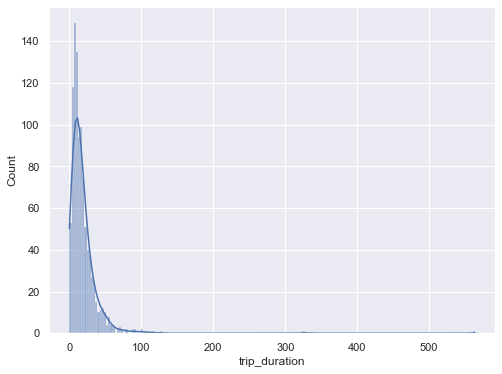

In [ ]:
# checking the distribution of 'trip_duration'
subset = df_jan.sample(n=1000)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
plot = sns.histplot(axes=ax, data=subset, x='trip_duration', kde=True);

In [ ]:
jan_nrows = df_jan.shape[0]
df_jan = df_jan[(df_jan['trip_duration'] >= 1) & (df_jan['trip_duration'] <= 60)]
print(f"No. of rows dropped : {jan_nrows - df_jan.shape[0]}")

No. of rows dropped : 44286


***

- **Q3. Missing values**

    - What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.?

In [ ]:
df_jan.fillna(value=-1, inplace=True)

In [ ]:
print(f"{round(((df_jan[df_jan['PUlocationID'] == -1].shape[0]) / df_jan.shape[0])*100, 2)} %")

83.53 %


***

- **Q4. One-hot encoding**

    - Apply one-hot encoding to the pickup and dropoff location IDs. Fit a dictionary vectorizer and get a feature matrix from it. What's the dimensionality of this matrix? (The number of columns).

In [ ]:
from sklearn.feature_extraction import DictVectorizer

In [ ]:
train_columns = ['PUlocationID', 'DOlocationID']
X_train = df_jan[train_columns].astype(str).to_dict(orient='records')

dv = DictVectorizer()
X_train_dict = dv.fit_transform(X_train)

In [ ]:
X_train_dict

<1109826x525 sparse matrix of type '<class 'numpy.float64'>'
	with 2219652 stored elements in Compressed Sparse Row format>

In [ ]:
target = 'trip_duration'
y_train = df_jan[target].values
y_train[:5]

array([17.        , 17.        ,  8.28333333, 15.21666667,  9.05      ])

***

- **Q5. Training a model**

    - Train a plain linear regression model with default parameters. What's the RMSE on train?

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
lr = LinearRegression()
lr.fit(X_train_dict, y_train)

LinearRegression()

In [ ]:
y_pred = lr.predict(X_train_dict)
mean_squared_error(y_train, y_pred, squared=False)

10.528519107212675

***

- **Q6. Evaluating the model**

    - Apply this model to the validation dataset (Feb 2021). What's the RMSE on validation?

In [ ]:
df_feb.fillna(value=-1, inplace=True)

df_feb = df_feb[(df_feb['trip_duration'] >= 1) & (df_feb['trip_duration'] <= 60)]

X_val = df_feb[train_columns].astype(str).to_dict(orient='records')

X_val_dict = dv.transform(X_val)

y_val = df_feb[target].values

y_val[:5]

array([10.66666667, 14.56666667,  7.95      , 13.8       ,  8.96666667])

In [ ]:
y_pred = lr.predict(X_val_dict)

mean_squared_error(y_val, y_pred, squared=False)

11.014283191827879

***
***